In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from xgboost import XGBClassifier


In [46]:
train = pd.read_csv('/kaggle/input/newdataset1/multiclass_crop_dataset_reasonable.csv')

In [47]:
train.isnull().sum()
train['Crop_Type'] = train['Crop_Type'].fillna(train['Crop_Type'].mode()[0])

num_cols = train.select_dtypes(include='number').columns
cat_cols = train.select_dtypes(include='object').columns.drop('Crop_Type') 

for col in num_cols:
    train[col] = train[col].fillna(train[col].median())
#run only if categorical columns exists
for col in cat_cols:
    train[col] = train[col].fillna(train[col].mode()[0])


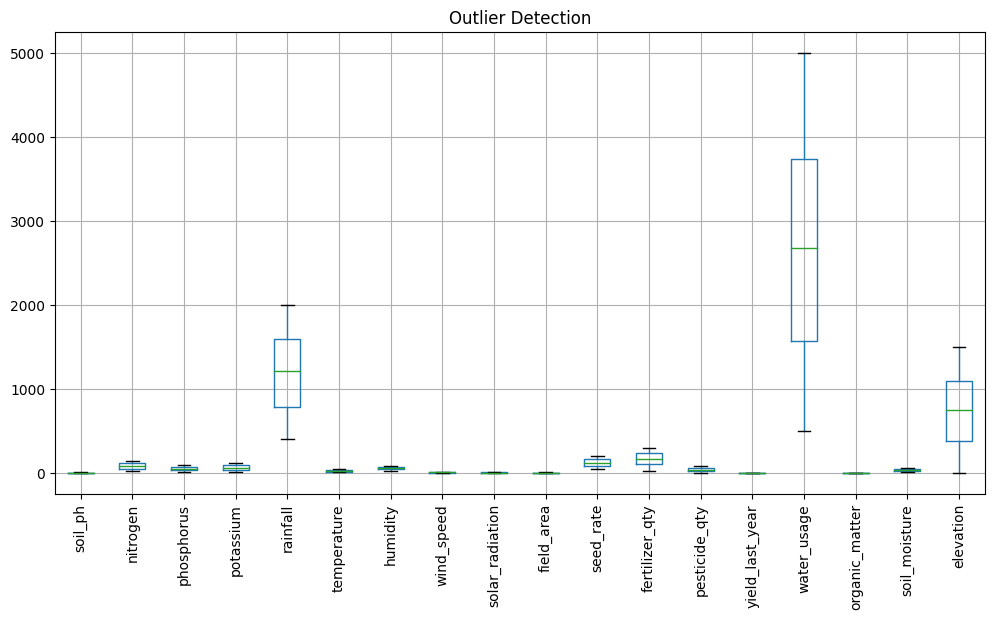

In [48]:
plt.figure(figsize=(12,6))
train[num_cols].boxplot(rot=90)
plt.title("Outlier Detection")
plt.show()

In [49]:
for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    train[col] = np.clip(
        train[col],
        Q1 - 1.5 * IQR,
        Q3 + 1.5 * IQR
    )

In [50]:
# run only if train dataset has input catagorical columns
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)

le = LabelEncoder()
train['Crop_Type'] = le.fit_transform(train['Crop_Type'])

In [51]:
X = train.drop('Crop_Type', axis=1)
y = train['Crop_Type']

In [52]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [53]:
param_dist = {
    'n_estimators': [300, 500, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}


In [54]:
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)


In [55]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True   # 🔑 IMPORTANT
)


random_search.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           n_estimators=None, n_jobs=-1,
                                           num_class=4, num_parallel_tree=None, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [4, 6, 8],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [300, 500, 800],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=1)

In [56]:
best_model = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)


Best Parameters: {'subsample': 0.8, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best CV Score: 0.9685724176170915


In [57]:
y_pred = best_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))


Validation Accuracy: 0.9683333333333334


In [58]:
y_proba = best_model.predict_proba(X_val_scaled)

roc_auc = roc_auc_score(
    y_val,
    y_proba,
    multi_class='ovr',
    average='macro'
)

print("Multiclass ROC-AUC:", roc_auc)


Multiclass ROC-AUC: 0.991667937226578


In [59]:
print("Train Accuracy:", best_model.score(X_train_scaled, y_train))
print("Val Accuracy:", best_model.score(X_val_scaled, y_val))


Train Accuracy: 1.0
Val Accuracy: 0.9683333333333334


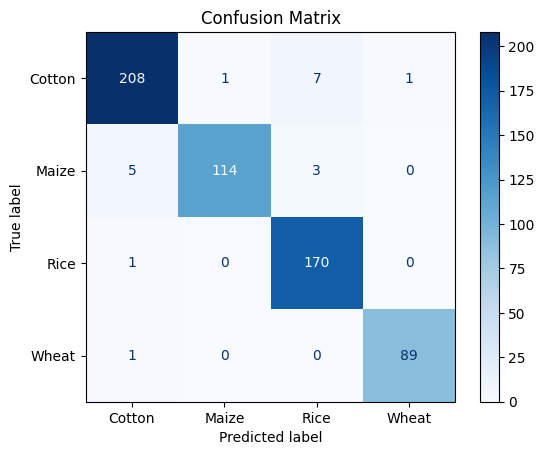

In [60]:
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


<Figure size 1000x800 with 0 Axes>

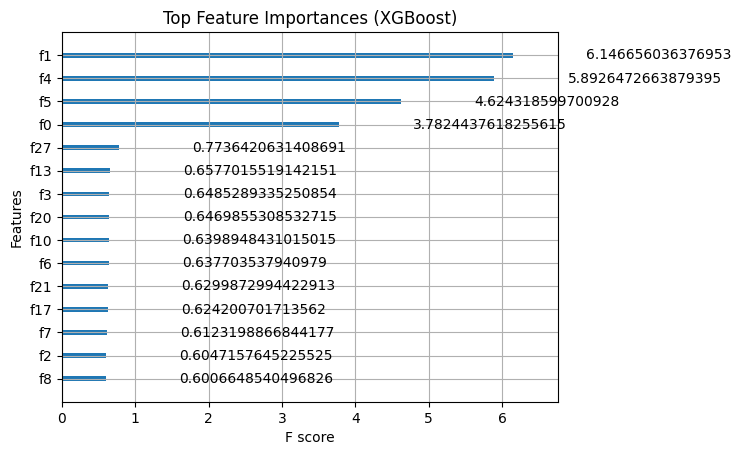

In [61]:
# ==============================
# PLOT A: Feature Importance
# ==============================
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(
    best_model,
    max_num_features=15,
    importance_type='gain'
)
plt.title("Top Feature Importances (XGBoost)")
plt.show()


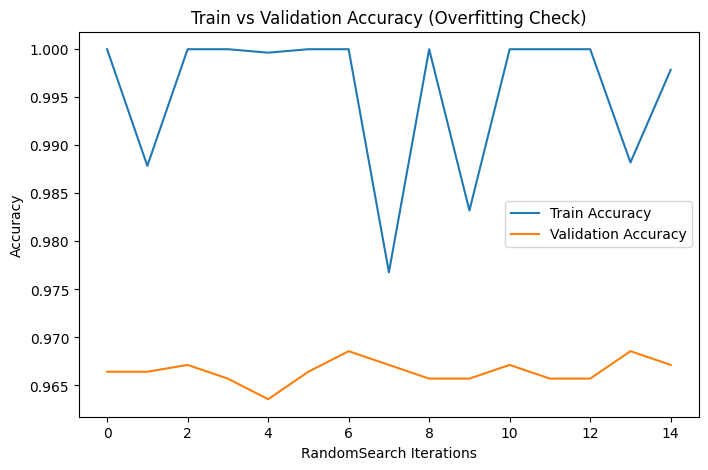

In [62]:
results = random_search.cv_results_

plt.figure(figsize=(8, 5))
plt.plot(results['mean_train_score'], label='Train Accuracy')
plt.plot(results['mean_test_score'], label='Validation Accuracy')
plt.xlabel("RandomSearch Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train vs Validation Accuracy (Overfitting Check)")
plt.show()


In [63]:
test = pd.read_csv('/kaggle/input/testdataset/multiclass_crop_test_dataset_reasonable.csv')
test.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,soil_ph,nitrogen,phosphorus,potassium,rainfall,temperature,humidity,wind_speed,solar_radiation,field_area,...,water_usage,organic_matter,soil_moisture,elevation,soil_type,irrigation_type,region,season,fertilizer_type,seed_variety
0,7.189114,34.0,22.0,57.0,454.388063,37.120148,37.834827,2.828232,3.627184,9.234337,...,NaN,2.799962,47.076785,729.750832,Clay,Canal,East,Zaid,NPK,Local
1,6.452314,49.0,43.0,106.0,700.125429,41.236980,58.458378,2.863675,8.760032,6.536678,...,2093.395503,0.855289,50.635555,301.179996,Clay,Canal,West,Zaid,DAP,Hybrid
2,7.801981,105.0,96.0,68.0,932.199466,24.164058,58.046685,10.060997,4.226716,5.985787,...,1681.308748,4.172576,56.876139,637.990711,Clay,Rainfed,West,Kharif,DAP,Hybrid
3,4.625786,69.0,63.0,63.0,1989.342045,28.626854,67.600814,1.236717,6.360442,1.074067,...,2631.998491,4.317286,20.706316,723.476989,Loamy,Canal,East,Rabi,NPK,Hybrid
4,7.732200,95.0,78.0,113.0,1852.551206,22.870304,51.425639,4.606343,3.331367,2.059278,...,4259.906530,3.638493,29.562967,318.187618,Clay,Rainfed,North,Zaid,Urea,Hybrid


In [64]:
test.isnull().sum()
num_cols = test.select_dtypes(include='number').columns
cat_cols = test.select_dtypes(include='object').columns

for col in num_cols:
    test[col] = test[col].fillna(test[col].median())

for col in cat_cols:
    test[col] = test[col].fillna(test[col].mode()[0])


In [ ]:
test_ids=test['id']

In [ ]:
test=test.drop("id",axis=1)

In [65]:
# only if categorical data is present in input
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)
# align columns with training data
test = test.reindex(columns=X.columns, fill_value=0)


In [66]:
test_scaled = scaler.transform(test)
test_preds = best_model.predict(test_scaled)


In [67]:
final_predictions = le.inverse_transform(test_preds)
final_predictions[:10]


array(['Cotton', 'Cotton', 'Maize', 'Rice', 'Cotton', 'Cotton', 'Rice',
       'Cotton', 'Rice', 'Wheat'], dtype=object)

In [68]:
#change Predicted_Crop_Type name to something else
submission = pd.DataFrame({
    "id": test_ids,
    "Predicted_Crop_Type": final_predictions
})

submission.to_csv("test_predictions_reasonable.csv", index=False)
